
# Titanic — Pipeline Didático com RF / GB / LR e Calibração de Probabilidades

Este notebook apresenta um **pipeline completo de ML** no Titanic com:
- **Pré-processamento** (`SimpleImputer`, `OneHotEncoder`, `ColumnTransformer`)
- **Modelagem**: `LogisticRegression`, `RandomForestClassifier`, `GradientBoostingClassifier`
- **Validação**: `StratifiedKFold` + `GridSearchCV` (métrica **ROC AUC**)
- **Calibração de probabilidades** com `CalibratedClassifierCV` (método **sigmoid/Platt**)
- **Avaliação didática**: métricas, curvas ROC, **curvas de confiabilidade (calibration curves)** antes e depois da calibração
- **Submissão** (CSV)

> Coloque `train.csv` e `test.csv` na pasta `./data` (ou ajuste o caminho).


## 1) Imports e setup

In [14]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import (roc_auc_score, accuracy_score, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report, RocCurveDisplay, brier_score_loss)
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay, calibration_curve

SEED = 42
np.random.seed(SEED)

DATA_DIR = ""
train_path = os.path.join(DATA_DIR, "train.csv")
test_path  = os.path.join(DATA_DIR, "test.csv")


## 2) Carregar dados

In [15]:

train = pd.read_csv(train_path)
test  = pd.read_csv(test_path)
print(train.shape)
train.head()


(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 3) EDA rápida (balanceamento de classes e sinais óbvios)

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Balanceamento do alvo (Survived):
Survived
0    0.616162
1    0.383838
Name: ratio, dtype: float64


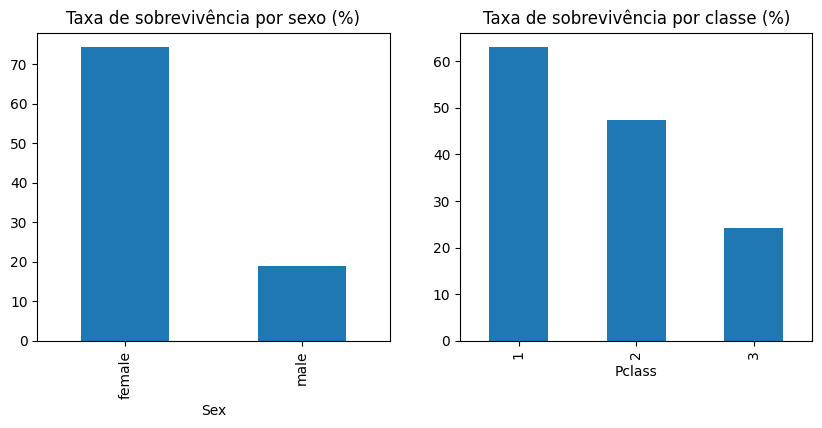

In [16]:

print(train.dtypes)
print("\nBalanceamento do alvo (Survived):")
print(train["Survived"].value_counts(normalize=True).rename("ratio"))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
(train.groupby("Sex")["Survived"].mean()*100).plot(kind="bar", ax=ax[0])
ax[0].set_title("Taxa de sobrevivência por sexo (%)")
(train.groupby("Pclass")["Survived"].mean()*100).plot(kind="bar", ax=ax[1])
ax[1].set_title("Taxa de sobrevivência por classe (%)")
plt.show()


## 4) Seleção de features e pré-processamento

In [17]:

TARGET = "Survived"
FEATURES_NUM = ["Age", "SibSp", "Parch", "Fare"]
FEATURES_CAT = ["Pclass", "Sex", "Embarked"]
FEATURES_ALL = FEATURES_NUM + FEATURES_CAT

X = train[FEATURES_ALL]
y = train[TARGET]

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipeline, FEATURES_NUM),
        ("cat", categorical_pipeline, FEATURES_CAT),
    ]
)


## 5) Modelos (LR, RF, GB) e pipelines

In [18]:

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=SEED),
    "RandomForest": RandomForestClassifier(random_state=SEED),
    "GradientBoosting": GradientBoostingClassifier(random_state=SEED)
}

pipelines = {name: Pipeline(steps=[("prep", preprocessor), ("clf", model)]) for name, model in models.items()}


## 6) Validação (StratifiedKFold) + GridSearchCV (ROC AUC)

In [19]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

param_grids = {
    "LogisticRegression": {"clf__C": [0.1, 1.0, 3.0, 10.0]},
    "RandomForest": {"clf__n_estimators": [200, 500], "clf__max_depth": [None, 5, 8, 12]},
    "GradientBoosting": {"clf__n_estimators": [100, 300], "clf__learning_rate": [0.05, 0.1], "clf__max_depth": [2, 3, 4]}
}

best_results = {}
for name, pipe in pipelines.items():
    print(f"=== Treinando {name} ===")
    search = GridSearchCV(pipe, param_grids[name], scoring="roc_auc", cv=cv, n_jobs=-1)
    search.fit(X, y)
    print(f"Melhores parâmetros: {search.best_params_} | AUC = {search.best_score_:.4f}\n")
    best_results[name] = search

best_model_name = max(best_results, key=lambda k: best_results[k].best_score_)
best_search = best_results[best_model_name]
best_model = best_search.best_estimator_
print(f"Melhor modelo selecionado: {best_model_name}")


=== Treinando LogisticRegression ===


Melhores parâmetros: {'clf__C': 10.0} | AUC = 0.8514

=== Treinando RandomForest ===
Melhores parâmetros: {'clf__max_depth': 8, 'clf__n_estimators': 200} | AUC = 0.8761

=== Treinando GradientBoosting ===
Melhores parâmetros: {'clf__learning_rate': 0.1, 'clf__max_depth': 2, 'clf__n_estimators': 300} | AUC = 0.8772

Melhor modelo selecionado: GradientBoosting


## 7) Avaliação do melhor modelo (antes da calibração)

AUC médio (CV): 0.8772 ± 0.0174
ACC médio (CV): 0.8328 ± 0.0147

Relatório de classificação (treino):
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       549
           1       0.90      0.82      0.86       342

    accuracy                           0.89       891
   macro avg       0.90      0.88      0.89       891
weighted avg       0.89      0.89      0.89       891



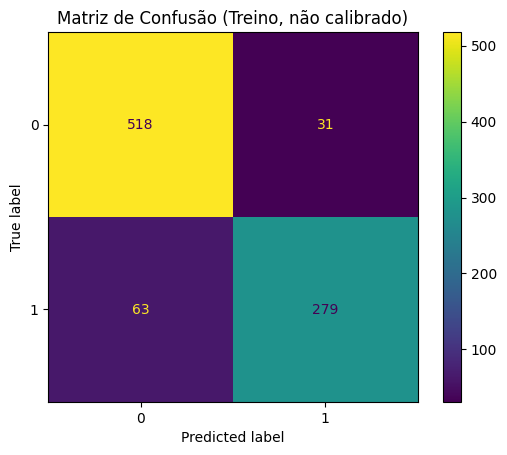

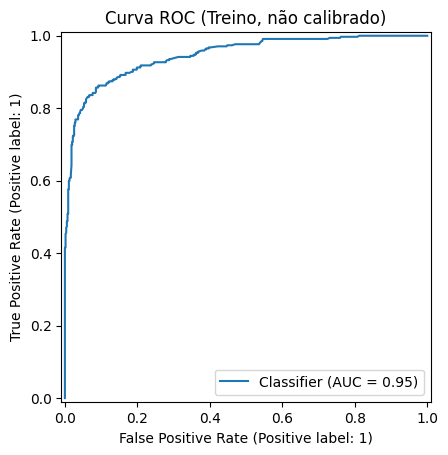

Brier score (quanto menor, melhor) - não calibrado: 0.08549899651486098


In [20]:

auc_scores = cross_val_score(best_model, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
acc_scores = cross_val_score(best_model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)

print(f"AUC médio (CV): {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
print(f"ACC médio (CV): {acc_scores.mean():.4f} ± {acc_scores.std():.4f}")

best_model.fit(X, y)
y_pred_raw = best_model.predict(X)
y_proba_raw = best_model.predict_proba(X)[:, 1]

print("\nRelatório de classificação (treino):\n", classification_report(y, y_pred_raw))
ConfusionMatrixDisplay(confusion_matrix(y, y_pred_raw)).plot()
plt.title("Matriz de Confusão (Treino, não calibrado)")
plt.show()

RocCurveDisplay.from_predictions(y, y_proba_raw)
plt.title("Curva ROC (Treino, não calibrado)")
plt.show()

print("Brier score (quanto menor, melhor) - não calibrado:", brier_score_loss(y, y_proba_raw))


## 8) Calibração de Probabilidades (CalibratedClassifierCV)

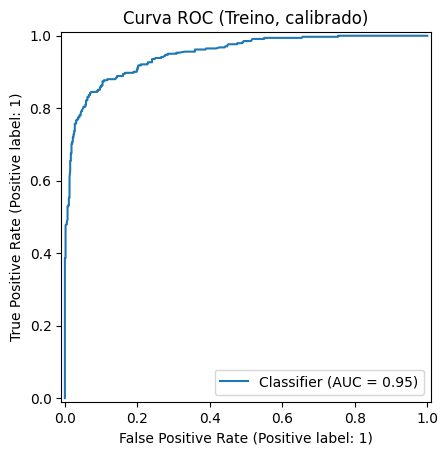

AUC após calibração: 0.9497038741358557
Brier score (menor é melhor) - calibrado: 0.0882983326665656


In [21]:

calibrated_model = CalibratedClassifierCV(best_model.named_steps["clf"], cv=cv, method="sigmoid")

# O calibrador recebe X já pré-processado
X_prepared = best_model.named_steps["prep"].fit_transform(X)
calibrated_model.fit(X_prepared, y)

y_proba_cal = calibrated_model.predict_proba(X_prepared)[:, 1]

RocCurveDisplay.from_predictions(y, y_proba_cal)
plt.title("Curva ROC (Treino, calibrado)")
plt.show()

print("AUC após calibração:", roc_auc_score(y, y_proba_cal))
print("Brier score (menor é melhor) - calibrado:", brier_score_loss(y, y_proba_cal))


### 8.1) Curvas de confiabilidade (antes vs. depois da calibração)

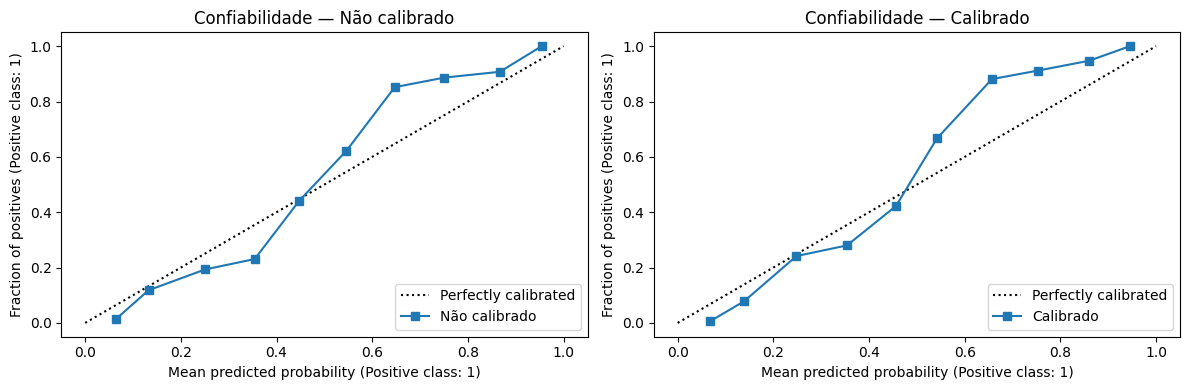

In [22]:

fig, ax = plt.subplots(1, 2, figsize=(12,4))
CalibrationDisplay.from_predictions(y_true=y, y_prob=y_proba_raw, n_bins=10, name="Não calibrado", ax=ax[0])
ax[0].set_title("Confiabilidade — Não calibrado")
CalibrationDisplay.from_predictions(y_true=y, y_prob=y_proba_cal, n_bins=10, name="Calibrado", ax=ax[1])
ax[1].set_title("Confiabilidade — Calibrado")
plt.tight_layout()
plt.show()


## 9) Interpretação de features

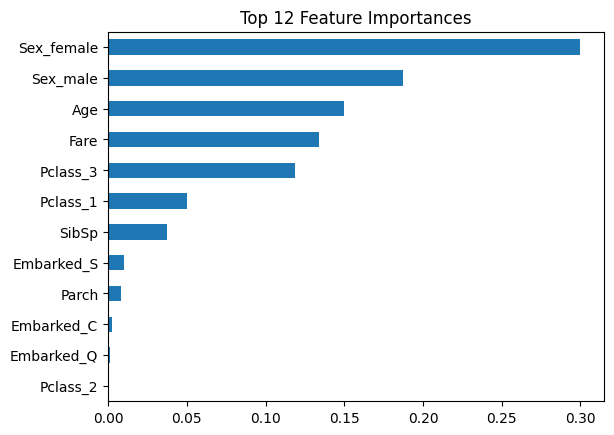

In [23]:

cat_ohe = best_model.named_steps["prep"].named_transformers_["cat"].named_steps["ohe"]
cat_feature_names = list(cat_ohe.get_feature_names_out(FEATURES_CAT))
all_feature_names = FEATURES_NUM + cat_feature_names

clf = best_model.named_steps["clf"]
if hasattr(clf, "feature_importances_"):
    fi = pd.Series(clf.feature_importances_, index=all_feature_names).sort_values(ascending=False)
    ax = fi.head(12).plot(kind="barh", title="Top 12 Feature Importances")
    ax.invert_yaxis()
    plt.show()
elif hasattr(clf, "coef_"):
    coefs = pd.Series(clf.coef_[0], index=all_feature_names).sort_values(key=lambda s: s.abs(), ascending=False)
    ax = coefs.head(12).plot(kind="barh", title="Top 12 Coefficients (|value|)")
    ax.invert_yaxis()
    plt.show()
else:
    print("O classificador não expõe importâncias/coefs diretamente.")



---
## Recado didático — Entendendo o Pipeline
- O **ColumnTransformer** garante *preprocessamento reprodutível*: imputação (num/cat) e codificação OHE.
- **GridSearchCV + StratifiedKFold** com métrica **ROC AUC** compara modelos de forma justa.
- **Probabilidades calibradas** são mais confiáveis para decisões orientadas a risco e thresholds custo-dependentes.
- **Brier score** mede a qualidade da probabilidade (menor é melhor); **calibração** tende a reduzir esse erro.
